In [69]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt

In [77]:
def download_stock_data(ticker, start_date, end_date):
    """ Download historical stock data from Yahoo Finance. """
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Returns'] = data['Adj Close'].pct_change()
    return data

def calculate_monthly_median(data):
    """Calculate the median of monthly returns to establish bullish and bearish thresholds."""
    monthly_data = data['Adj Close'].resample('M').ffill().pct_change()
    median_monthly_return = monthly_data.median()
    return median_monthly_return

def classify_returns(data, median_monthly_return):
    """Classify all returns in the dataset based on monthly median return."""
    daily_return = median_monthly_return / 30**(0.5)
    data.loc[:, 'Class'] = data['Returns'].apply(lambda x: 'Bullish' if x > daily_return else 'Bearish')
    return data

def calculate_rolling_distances(data, window_size):
    """Calculate rolling Wasserstein distances for bullish and bearish returns."""
    bullish_data = data.loc[data['Class'] == 'Bullish', 'Returns'].dropna()
    bearish_data = data.loc[data['Class'] == 'Bearish', 'Returns'].dropna()

    data['Bullish Distance'] = data['Returns'].rolling(window=window_size).apply(
        lambda x: wasserstein_distance(x.dropna(), bullish_data), raw=False)
    data['Bearish Distance'] = data['Returns'].rolling(window=window_size).apply(
        lambda x: wasserstein_distance(x.dropna(), bearish_data), raw=False)

    return data

def calculate_thresholds(data, percentile=68):
    """Calculate dynamic thresholds based on historical distances percentile."""
    bullish_threshold = data['Bullish Distance'].dropna().quantile(percentile / 100)
    bearish_threshold = data['Bearish Distance'].dropna().quantile(percentile / 100)
    return bullish_threshold, bearish_threshold


def plot_distances(data, start_date, bullish_threshold, bearish_threshold):
    """Plot Wasserstein distances with dynamic thresholds and highlight areas beyond thresholds."""
    plt.figure(figsize=(14, 7))
    dates = data.loc[start_date:].index
    bullish_distances = data.loc[start_date:, 'Bullish Distance']
    bearish_distances = data.loc[start_date:, 'Bearish Distance']

    plt.plot(dates, bullish_distances, label='Distance to Bullish Returns')
    plt.plot(dates, bearish_distances, label='Distance to Bearish Returns')
    plt.axhline(y=bullish_threshold, color='green', linestyle='--', label=f'Bullish Threshold: {bullish_threshold:.5f}')
    plt.axhline(y=bearish_threshold, color='red', linestyle='--', label=f'Bearish Threshold: {bearish_threshold:.5f}')

    # Fill areas where distances exceed the thresholds
    plt.fill_between(dates, bullish_distances, bullish_threshold, where=(bullish_distances > bullish_threshold), color='green', alpha=0.3, label='Above Bullish Threshold')
    plt.fill_between(dates, bearish_distances, bearish_threshold, where=(bearish_distances > bearish_threshold), color='red', alpha=0.3, label='Above Bearish Threshold')

    plt.legend()
    plt.title('Wasserstein Distances to Historical Bullish and Bearish Returns')
    plt.show()


In [71]:
data = download_stock_data('MSFT', '2000-01-01', '2024-01-01')

[*********************100%***********************]  1 of 1 completed


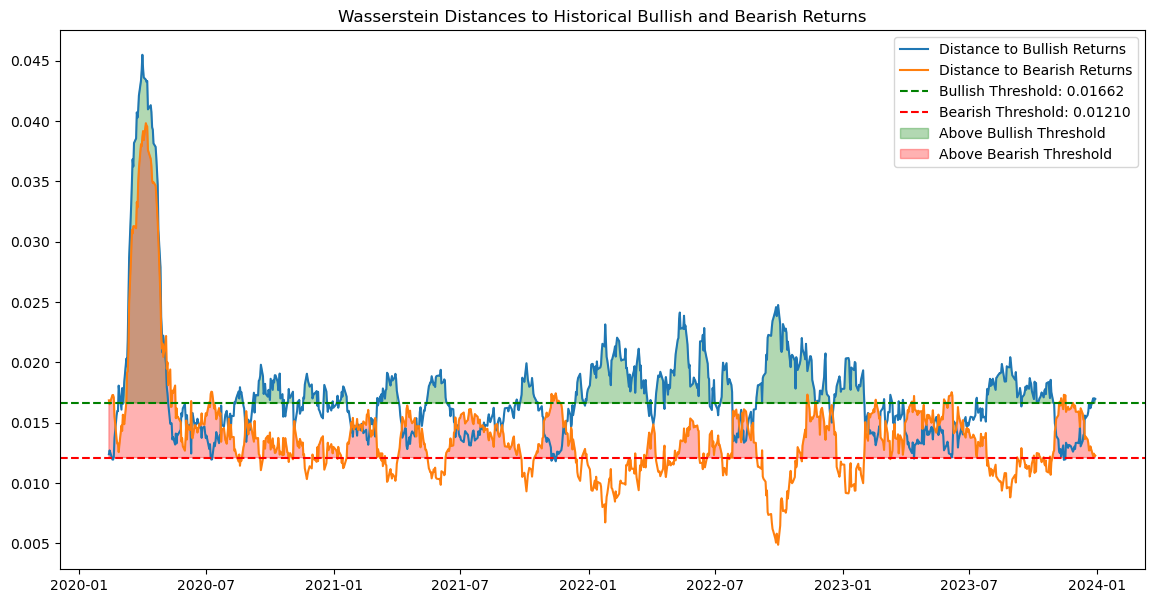

In [80]:
test_start = '2020-01-01'
train_data = data[:test_start]

# Calculate median from training set
median_monthly_return = calculate_monthly_median(train_data)

# Classify returns in the entire dataset
data = classify_returns(data, median_monthly_return)

# Calculate rolling distances using a specified window size
window_size = 30  # days
test_data = data[test_start:].copy()
distances = calculate_rolling_distances(test_data, window_size)

bullish_threshold, bearish_threshold = calculate_thresholds(train_data, percentile=68)

# Plotting distances with thresholds
plot_distances(distances, test_start, bullish_threshold, bearish_threshold)